In the following analysis we used the public dataset:

Llorens-Bobadilla, Enric, et al. "Single-cell transcriptomics reveals a population of dormant neural stem cells that become activated upon brain injury." Cell Stem Cell 17.3 (2015): 329-340.
http://dx.doi.org/10.1016/j.stem.2015.07.002

Processed data was downloaded from GEO website: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE67833

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
from scipy import stats
import scikits.bootstrap as boot

%matplotlib inline
cmap=cm.get_cmap('RdBu_r')
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})

path_dropbox = '~/Dropbox/'
# path_dropbox = '/Users/marcelob/Dropbox/'

# calculates the correlation between two genes
def pcorr(x,y, log_scale=False):
    if log_scale:
        x = np.log2(x)
        y = np.log2(y)
    [corr,p] = pearsonr(x, y)
    a,b   = np.polyfit(x, y, 1) 
    return [corr, p, a, b]

# calculate the expression of a list of genes defined in D['list_genes] in the log2(X+1) scale
def get_expression(D):
    out = []
    for i in range(len(D['list_genes'])):
        out += [np.sum(D['data'].loc[D['list_genes'][i]].values, axis=0)]
    return np.log2(np.array(out)+1)

# convert ensembl ID to gene name
Xi = pd.read_csv(path_dropbox+'data/Llorens_Bobadilla/Ensembl_IDs.txt', index_col=None, header=0)
def ensembl_to_geneID(Xi, g):
    return [[Xi[Xi['WikiGene Name']==i]['Ensembl Gene ID'].values[0] for i in g[j]] for j in range(len(g))]

In [2]:
# Reading downloaded processed data from GEO site
X1 = pd.read_csv(path_dropbox+'data/Llorens_Bobadilla/GSE67833_Gene_expression_matrix.csv',  
                 index_col=0, header=0)
X2 = pd.read_csv(path_dropbox+'data/Llorens_Bobadilla/GSE67833_Gene_expression_matrix_GSM1684656-704.csv', 
                 index_col=0, header=0)


D = {}
D['data'] = pd.concat([X1, X2], axis=1, join='inner')

cl = pd.DataFrame(index=['cl'], columns=D['data'].columns)
for i in cl.columns: 
    if i[0] == 'N':    # control NSCs
        cl[i] = 0.0
    elif i[0] == 't':  # TAP cells
        cl[i] = 1.0

D['data']   = D['data'][cl.columns[cl.loc['cl']<=1]]
cl   = cl[cl.columns[cl.loc['cl']<=1]]
D['marker'] = np.array([str(i).replace('0.0','o').replace('1.0','>') for i in cl.values[0]])

print 'Number of NSC  =', np.sum(cl.values==0.0)
print 'Number of tap  =', np.sum(cl.values==1.0)
D['data'].head()

Number of NSC  = 130
Number of tap  = 27


,N1,N11,N13,N17,N18,N2,N22,N23,N24,N25,...,tap62,tap61,tap60,tap59,tap58,tap56,tap55,tap54,tap50,tap49
ENSMUSG00000099985,0.000,0.000,0.038,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ENSMUSG00000030105,16.498,0.000,0.089,0.00,63.615,0.068,312.755,88.253,76.513,0.000,...,58.356,64.274,115.027,0.000,94.013,137.899,74.606,91.661,101.311,139.724
ENSMUSG00000098001,0.509,0.252,0.051,0.43,0.264,0.361,0.168,0.122,0.190,0.327,...,0.940,0.486,1.629,0.135,0.498,0.893,0.305,0.000,0.591,0.327
ENSMUSG00000096054,0.000,0.511,0.000,0.00,0.000,0.090,0.042,3.288,0.000,57.626,...,0.097,0.045,0.092,0.000,0.000,0.045,0.000,0.000,0.357,0.187
ENSMUSG00000074445,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


(-1, 10)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


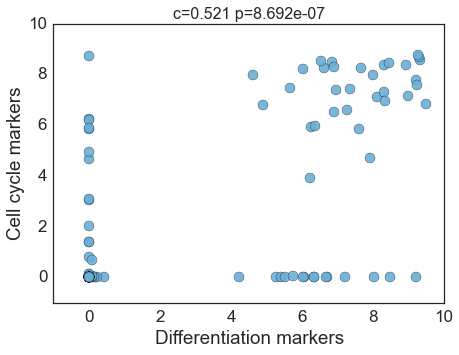

In [3]:
cmap = plt.cm.get_cmap('Blues')

diff_markers = ['Ascl1', 'Neurog2', 'Neurod6', 'Neurod2']
ccyc_markers = ['Mki67','Ccnd1', 'Mcm2']

D['list_genes'] = ensembl_to_geneID(Xi,[diff_markers, ccyc_markers])
x_data = get_expression(D)

x = x_data[0][(D['marker']=='o')]
y = x_data[1][(D['marker']=='o')]

f = plt.subplots(1, 1, figsize=(7, 5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
plt.subplots_adjust(wspace=0.8)
plt.scatter(x, y, cmap=cmap, c=cmap(0.5), marker='o', s=100, alpha=0.9)
plt.title('c=' +str(round(pcorr(x[(x+y)>0],y[(x+y)>0])[0],3))+
          ' p='+str(round(pcorr(x[(x+y)>0],y[(x+y)>0])[1],10)), size=16)
plt.xlabel('Differentiation markers')
plt.ylabel('Cell cycle markers')
plt.xlim([-1, 10])
plt.ylim([-1, 10])
#plt.savefig('Adult_mice_DiffxCCmarkers.pdf', format='pdf')

In [4]:
def resample(X, n=None):
    if n==None:
        n = np.shape(X)[1]
    resample_i = np.floor(np.random.rand(n)*np.shape(X)[1]).astype(int)
    X_resample = X[:,resample_i]
    return X_resample

X = x_data[:,(D['marker']=='o')]
X = X[:,np.mean(X,0)>0.0]

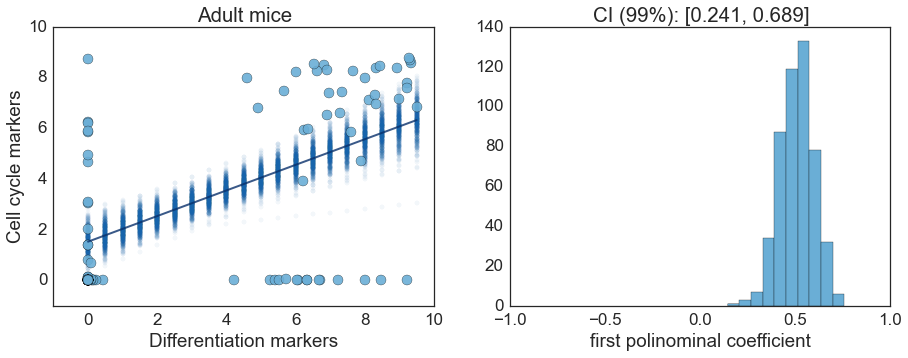

In [5]:
f = plt.subplots(1, 2, figsize=(15, 5))
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)

xr = np.arange(0, 10, 0.5)
n_sampling = 500
p = np.zeros((2, n_sampling))
for i in range(n_sampling):
    Xs = resample(X)
    p[:,i] = np.polyfit(Xs[0],Xs[1],1)
    plt.scatter(xr, p[0,i]*xr + p[1,i], color=cmap(0.8), alpha=0.05)

    
A, B = np.polyfit(X[0], X[1], 1)
plt.scatter(x, y, cmap=cmap, c=cmap(0.5), marker='o', s=100, alpha=0.9)
plt.plot(xr, A*xr + B, color=cmap(1.), alpha=0.8, lw=2)
plt.xlim([-1, 10])
plt.ylim([-1, 10])
plt.xlabel('Differentiation markers')
plt.ylabel('Cell cycle markers')
plt.title('Adult mice')

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
plt.hist(p[0,:], facecolor=cmap(0.5))
plt.xlim(-1, 1)
ci = boot.ci( (X[0,:],X[1,:]), statfunction=stats.linregress, alpha=0.01)
plt.title('CI (99%): ['+str(np.round(ci[0,0],3))+', '+str(np.round(ci[1,0],3))+']')
plt.xlabel('first polinominal coefficient')
#plt.savefig('Adult_mice_linearFit.pdf', format='pdf')

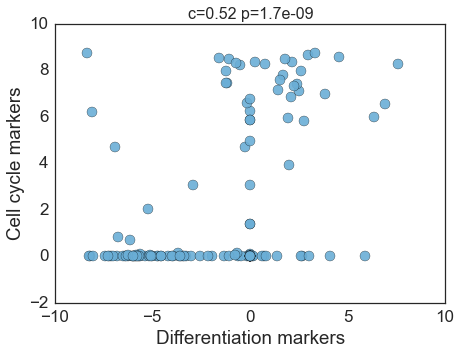

In [6]:
cmap = plt.cm.get_cmap('Blues')

diff_markers = ['Ascl1', 'Neurog2', 'Neurod6', 'Neurod2']
stem_markers = ['Sox2', 'Pax6']
ccyc_markers = ['Mki67','Ccnd1', 'Mcm2']

D['list_genes'] = ensembl_to_geneID(Xi,[diff_markers, stem_markers, ccyc_markers])
x_data = get_expression(D)

x = x_data[0][(D['marker']=='o')] - x_data[1][(D['marker']=='o')]
y = x_data[2][(D['marker']=='o')]

f = plt.subplots(1, 1, figsize=(7, 5))
ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
plt.subplots_adjust(wspace=0.8)
# plt.scatter(x1, x2, cmap=cmap, c=cmap(0.5), marker='o', s=100, alpha=0.9)
plt.scatter(x, y, cmap=cmap, c=cmap(0.5), marker='o', s=100, alpha=0.9)
plt.title('c=' +str(round(pcorr(x[np.abs(x+y)>0],y[np.abs(x+y)>0])[0],3))+
          ' p='+str(round(pcorr(x[np.abs(x+y)>0],y[np.abs(x+y)>0])[1],10)), size=16)
plt.xlabel('Differentiation markers')
plt.ylabel('Cell cycle markers')
# plt.xlim([-1, 10])
# plt.ylim([-1, 10])
#plt.savefig('Adult_mice_DiffxCCmarkers.pdf', format='pdf')

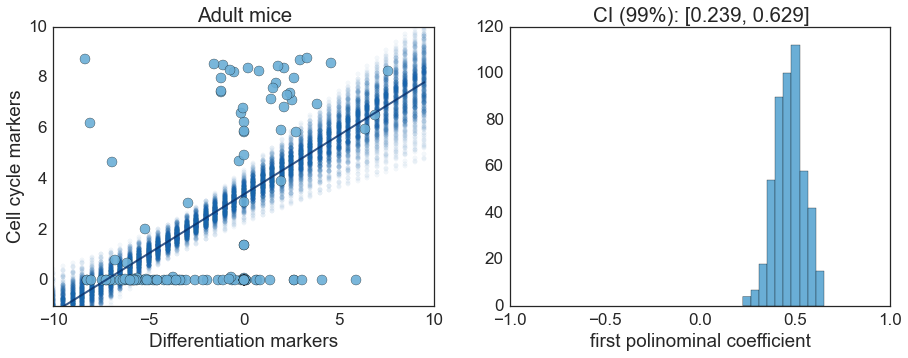

In [7]:
X = np.zeros((2, len(x)))
X[0,:] = x
X[1,:] = y
X = X[:,np.abs(np.mean(X,0))>0.0]

f = plt.subplots(1, 2, figsize=(15, 5))
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)

xr = np.arange(-10, 10, 0.5)
n_sampling = 500
p = np.zeros((2, n_sampling))
for i in range(n_sampling):
    Xs = resample(X)
    p[:,i] = np.polyfit(Xs[0],Xs[1],1)
    plt.scatter(xr, p[0,i]*xr + p[1,i], color=cmap(0.8), alpha=0.05)

    
A, B = np.polyfit(X[0], X[1], 1)
plt.scatter(x, y, cmap=cmap, c=cmap(0.5), marker='o', s=100, alpha=0.9)
plt.plot(xr, A*xr + B, color=cmap(1.), alpha=0.8, lw=2)
plt.xlim([-10, 10])
plt.ylim([-1, 10])
plt.xlabel('Differentiation markers')
plt.ylabel('Cell cycle markers')
plt.title('Adult mice')

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
plt.hist(p[0,:], facecolor=cmap(0.5))
plt.xlim(-1, 1)
ci = boot.ci( (X[0,:],X[1,:]), statfunction=stats.linregress, alpha=0.01)
plt.title('CI (99%): ['+str(np.round(ci[0,0],3))+', '+str(np.round(ci[1,0],3))+']')
plt.xlabel('first polinominal coefficient')
plt.savefig('Adult_mice_linearFit_2.pdf', format='pdf')

In [6]:
print A,B

0.504628401304 1.52944039146


In [6]:
glio = pd.read_csv('Glioblastoma.txt', index_col=1, header=0, sep='\t')
glio = glio.drop('GENE_ID', 1)
glio = glio.dropna(axis=1)
glio

,TCGA-32-4213-01,TCGA-15-1444-01,TCGA-76-4928-01,TCGA-28-5207-01,TCGA-28-2514-01,TCGA-06-2569-01,TCGA-06-0743-01,TCGA-32-2616-01,TCGA-06-5858-01,TCGA-06-0686-01,...,TCGA-27-2524-01,TCGA-06-0168-01,TCGA-19-1787-01,TCGA-06-5413-01,TCGA-06-0157-01,TCGA-32-2615-01,TCGA-26-5136-01,TCGA-12-1597-01,TCGA-14-0871-01,TCGA-06-2564-01
COMMON,,,,,,,,,,,,,,,,,,,,,
ASCL1,396.00,2758.00,838.00,2936.00,718.00,16.00,2499.00,4186.00,2850.00,1484.00,...,638.00,558.00,378.00,1913.00,3309.00,1535.00,1051,2838.00,7.00,3537.00
CCND1,922.55,6052.42,1645.71,2958.74,5347.48,5584.08,1401.95,2339.24,1662.64,1446.23,...,1508.21,365.82,1849.69,4434.71,5923.24,4397.53,659,3016.34,2522.21,3350.98
MCM2,1504.00,2543.00,2316.00,3024.00,2281.00,3363.00,1619.00,9400.00,4657.00,2042.00,...,2970.00,1591.00,8243.00,4072.00,5984.00,2454.00,1276,3306.00,891.00,2625.00
MKI67,411.00,1195.00,1922.00,928.00,2276.00,3482.00,828.00,6292.00,8012.00,1686.00,...,1078.00,359.00,8792.00,1699.00,1302.00,1712.00,703,1053.00,560.00,2047.00
NEUROD2,1.00,15.00,4.00,251.00,264.00,7.00,22.00,12.00,4.00,161.00,...,32.00,83.00,5.00,153.00,451.00,196.00,14,1499.00,1.00,112.00
NEUROD6,0.00,2.00,0.00,15.00,96.00,1.00,2.00,5.00,0.00,27.00,...,6.00,8.00,0.00,68.00,64.00,4.00,7,60.00,0.00,15.00
NEUROG2,2.00,13.00,1.00,4.00,3.00,1.00,69.00,4.00,2.00,4.00,...,4.00,0.00,22.00,12.00,8.00,2.00,0,2.00,0.00,2.00


In [7]:
info = pd.read_csv('Glioblastoma_info.tsv', index_col=1, header=0, sep='\t')
#subtype = np.array([info.loc[i]['Expression Subtype'] for i in glio.columns])
set(info['Expression Subtype'])
diff_markers = ['ASCL1', 'NEUROG2', 'NEUROD6', 'NEUROD2']
ccyc_markers = ['MKI67','CCND1', 'MCM2']

(0, 17.0)

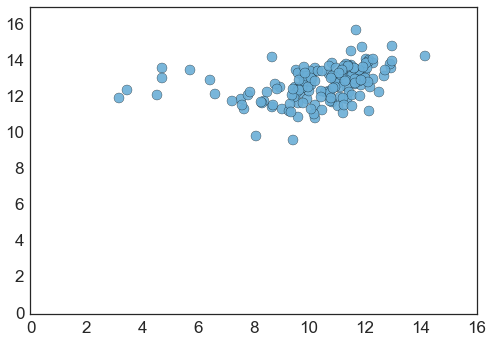

In [8]:
x = np.log2(np.sum(glio.loc[diff_markers].values, axis=0) + 1.0)
y = np.log2(np.sum(glio.loc[ccyc_markers].values, axis=0) + 1.0)
plt.scatter(x, y, cmap=cmap, c=cmap(0.5), marker='o', s=100, alpha=0.9)
plt.xlim(xmin=0)
plt.ylim(ymin=0)

In [18]:
X = np.zeros((2,len(x)))
X[0,:] = x
X[1,:] = y

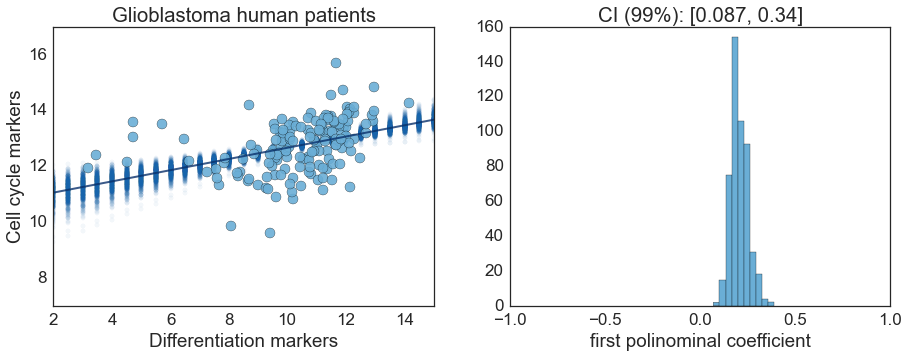

In [25]:
f = plt.subplots(1, 2, figsize=(15, 5))
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)

xr = np.arange(0, 16, 0.5)
n_sampling = 500
p = np.zeros((2, n_sampling))
for i in range(n_sampling):
    Xs = resample(X)
    p[:,i] = np.polyfit(Xs[0],Xs[1],1)
    plt.scatter(xr, p[0,i]*xr + p[1,i], color=cmap(0.8), alpha=0.05)

    
A, B = np.polyfit(X[0], X[1], 1)
plt.scatter(x, y, cmap=cmap, c=cmap(0.5), marker='o', s=100, alpha=0.9)
plt.plot(xr, A*xr + B, color=cmap(1.), alpha=0.8, lw=2)
plt.xlim([2, 15])
plt.ylim([7, 17])
plt.xlabel('Differentiation markers')
plt.ylabel('Cell cycle markers')
plt.title('Glioblastoma human patients')

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
plt.hist(p[0,:], facecolor=cmap(0.5))
plt.xlim(-1, 1)
ci = boot.ci( (X[0,:],X[1,:]), statfunction=stats.linregress, alpha=0.01)
plt.title('CI (99%): ['+str(np.round(ci[0,0],3))+', '+str(np.round(ci[1,0],3))+']')
plt.xlabel('first polinominal coefficient')
#plt.savefig('Glioblastoma_HumanPatients_linearFit.pdf', format='pdf')